Hi!

If you're here, you're probably interested on how the code can be used to segment a song in the NTD paradigm.

This is the goal of this notebook, which can work as a tutorial on how to use the code on your own. Of course, it's related to a version of the code (0.1.0), and should be regularly updated (but this is my job, not yours). Make sure nonetheless that the version you need is also the one of the current version of the notebook.

# Imports

In [1]:
# External imports
# Module for manipulating arrays
import numpy as np

# Module for loading signals
import soundfile as sf

# Module for manipulating signals, notably 
import librosa

C:\Users\amarmore\AppData\Local\Continuum\anaconda3\envs\NTD_segmentation\lib\site-packages\librosa\util\decorators.py:9: NumbaDeprecationWarning: An import was requested from a module that has moved location.
Import requested from: 'numba.decorators', please update to use 'numba.core.decorators' or pin to Numba version 0.48.0. This alias will not be present in Numba version 0.50.0.
  from numba.decorators import jit as optional_jit
C:\Users\amarmore\AppData\Local\Continuum\anaconda3\envs\NTD_segmentation\lib\site-packages\librosa\util\decorators.py:9: NumbaDeprecationWarning: An import was requested from a module that has moved location.
Import of 'jit' requested from: 'numba.decorators', please update to use 'numba.core.decorators' or pin to Numba version 0.48.0. This alias will not be present in Numba version 0.50.0.
  from numba.decorators import jit as optional_jit


First, if you work in a Jupyter environment, you need to add the folders containing the code to the PYPATH, as it won't find the code otherwise. This is made by the following lines.

(This is kind of a quick fix, and is not sustainable in the long-term, it should be modified in near future).

In [2]:
import sys
import os
if os.path.abspath('../sample') not in sys.path:
    sys.path.insert(0, os.path.abspath('../sample'))
if os.path.abspath('../model') not in sys.path:
    sys.path.insert(0, os.path.abspath('../model'))

Now, let's import the code we need. It's organized in modules, which should group "coherent" codes in themselves.

In [3]:
# Module encapsulating the computation of features from the signal
import features

# General module for manipulating data: conversion between time, bars, frame indexes, loading of data, ...
import data_manipulation as dm

# Module constructing the tensor, starting from the spectrogram
import tensor_factory as tf

# Module containing our NTD resolution algorithm
import NTD

# Module containing our algorithm used for segmenting the autosimilarity
import autosimilarity_segmentation as as_seg

# Plotting module
from current_plot import *

# Loading the song, its annotations, and preparing it

Now, we will load the song (as a wav).

For that, you need to modify the variable "song_path" in order to include your desired song.

Note that, if it's not "Come Together" from The Beatles, you will also need to load your annotation, and the variable "annotation_path".

In [4]:
# Song
song_path = "C:\\Users\\amarmore\\this_folder\\The Beatles - Come Together.wav" # TOMODIFY

# Load the song
the_signal, original_sampling_rate = sf.read(song_path)
sampling_rate = 44100 # Madmom needs a signal sampled at 44100Hz, or downbeat estimation won't work.
if original_sampling_rate != sampling_rate:
    the_signal = librosa.core.resample(np.asfortranarray(the_signal), original_sampling_rate, sampling_rate)

# Find and load the annotation
annotation_path = "..\\additional files\\The Beatles - Come Together.lab"

# change the following lines if you have developed your own loader for your annotations.
annotations = dm.get_segmentation_from_txt(annotation_path, "MIREX10")
references_segments = np.array(annotations)[:,0:2]

# Estimates the downbeats
bars = dm.get_bars_from_audio(song_path)

# Convert annotations in bars (for plotting them on barwise figures)
annotations_frontiers_barwise = dm.frontiers_from_time_to_bar(references_segments[:,1], bars)

C:\Users\amarmore\AppData\Local\Continuum\anaconda3\envs\NTD_segmentation\lib\site-packages\madmom\io\audio.py:493: WavFileWarning: Chunk (non-data) not understood, skipping it.
  file_sample_rate, signal = wavfile.read(filename, mmap=True)


## Compute the chromagram

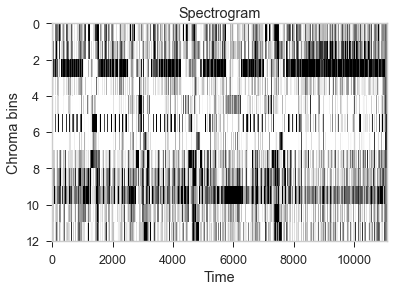

In [14]:
# We oversample the chromagram for the build of the tensor, see Notebook 3 for details
hop_length = 32
chromagram = features.get_spectrogram(the_signal, sampling_rate, "pcp", hop_length)
plot_me_this_spectrogram(chromagram[:,range(0,chromagram.shape[1], 32)], x_axis = "Time", y_axis = "Chroma bins")

## Build the tensor

In [6]:
hop_length_seconds = hop_length / sampling_rate
subdivision = 96

# Function which specifically builds the tensor
tensor_spectrogram = tf.tensorize_barwise(chromagram, bars, hop_length_seconds, subdivision)

# Decompose the song

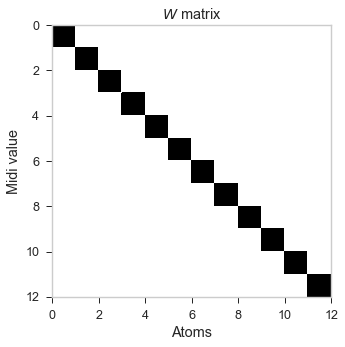

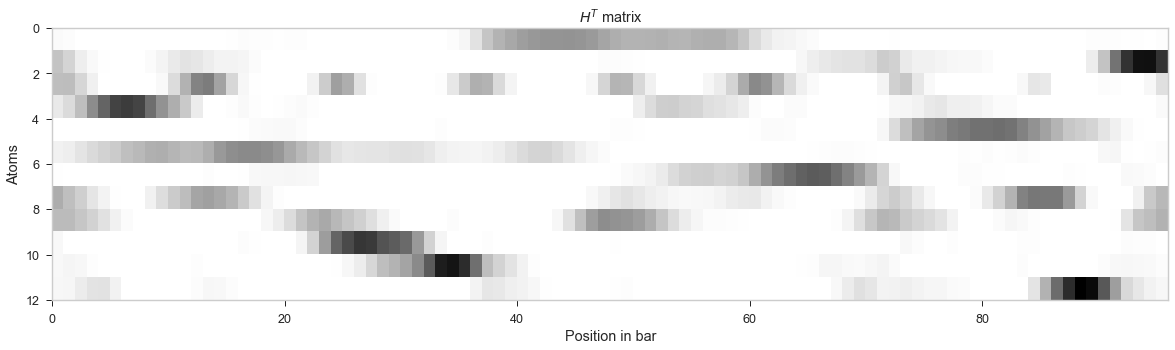

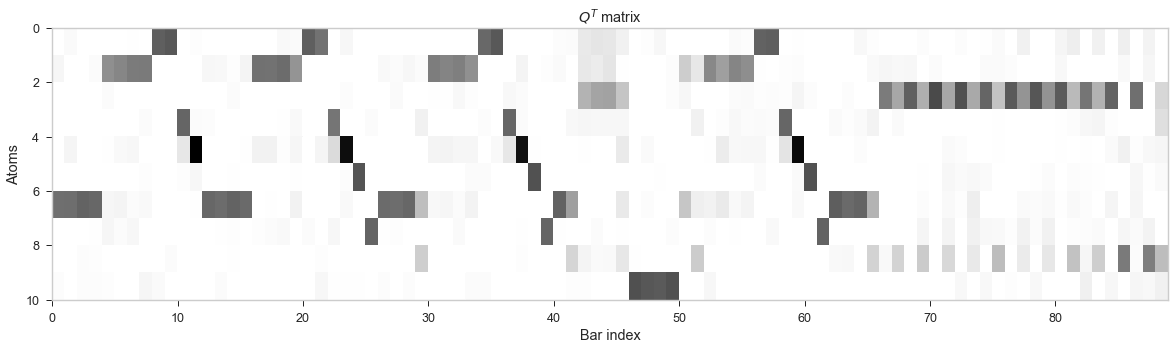

In [7]:
ranks = [12,12,10]
core, factors = NTD.ntd(tensor_spectrogram, ranks = ranks, init = "chromas", verbose = False, hals = False,deterministic = True,
                    sparsity_coefficients = [None, None, None, None], normalize = [True, True, False, True])

# Plotting the factors
plot_me_this_spectrogram(factors[0], figsize=(5,5), title = "$W$ matrix", x_axis = "Atoms", y_axis = "Midi value")
plot_me_this_spectrogram(factors[1].T, figsize=(20,5), title = "$H^T$ matrix", x_axis = "Position in bar", y_axis = "Atoms")
plot_me_this_spectrogram(factors[2].T, figsize=(20,5), title = "$Q^T$ matrix", x_axis = "Bar index", y_axis = "Atoms")

Note: "chromas" init corresponds to HO-SVD and fixing $W$ to the 12-identity.

Below is an enhanced vizualisation of the computed factors.

Indeed, reordering columns of the factors in a chronological make them easier to read as humans.

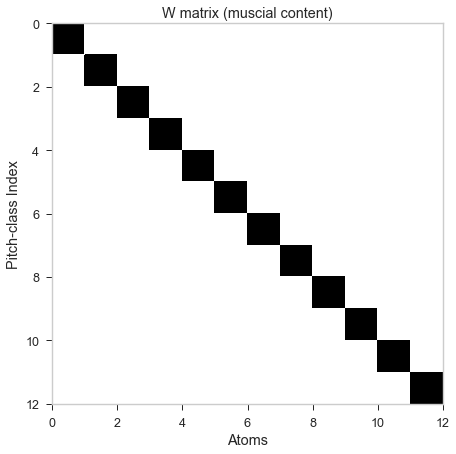

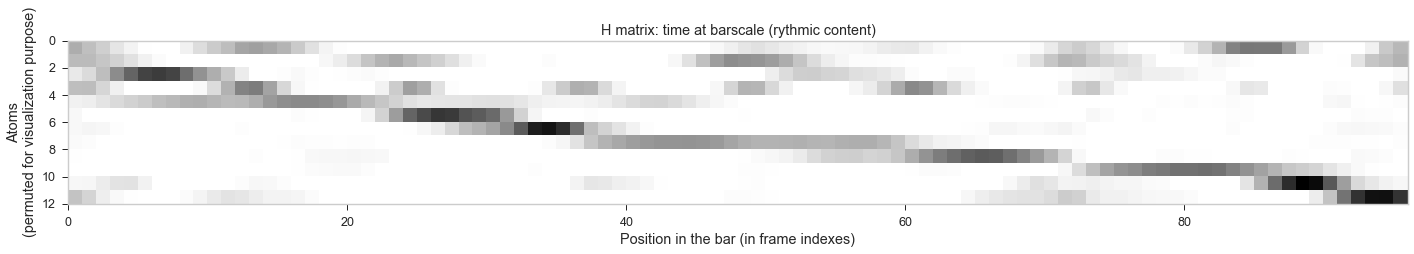

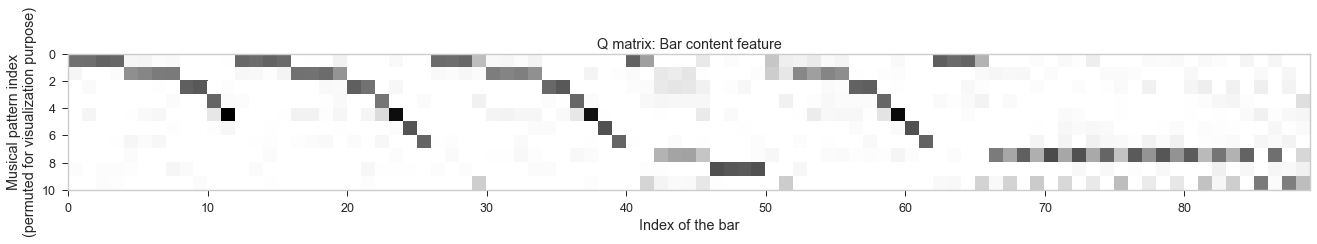

In [8]:
plot_permuted_tucker(factors, core, plot_core = False)

# Computing and segmenting the autosimilarity of $Q$

Now that we've decomposed the Time-Frequency-Bar tensor, we will compute the autosimilarity of $Q$.

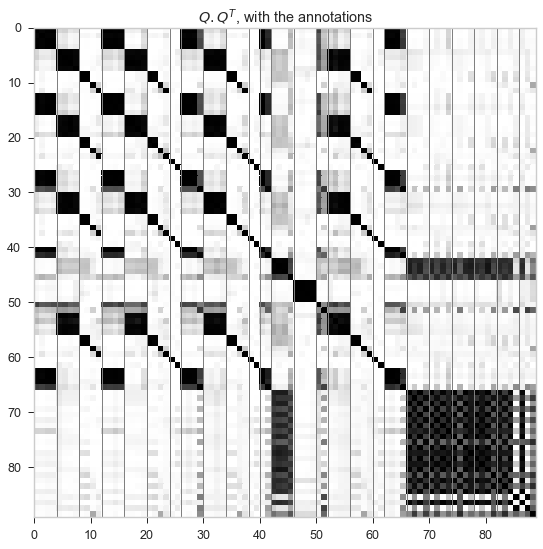

In [9]:
autosimilarity = as_seg.get_autosimilarity(factors[2], transpose = True, normalize = True)
plot_spec_with_annotations(autosimilarity, annotations_frontiers_barwise, color="grey", title = "$Q.Q^T$, with the annotations")

And segment it:

In [10]:
segments = as_seg.dynamic_convolution_computation(autosimilarity, penalty_weight = 1, penalty_func = "modulo8")[0]                
segments_in_time = dm.segments_from_bar_to_time(segments, bars)

Below are shown $Q^T$ and the autosimilarity, along with frontiers estimated by the algorithm:
 - <span style="color: green">In green, estimated frontiers which are correct (True Positives),</span>
 - <span style="color: orange">In orange, estimated frontiers which are incorrect (False Positives),</span>
 - <span style="color: #8080FF">In blue, frontiers from the reference which are not estimated (False Negatives).</span>

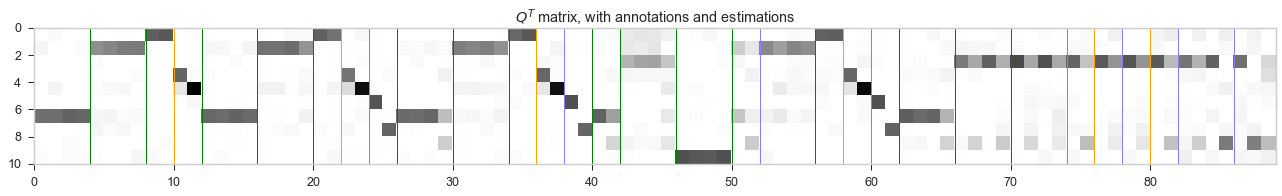

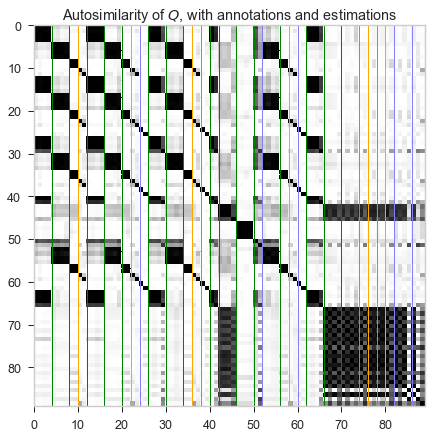

In [11]:
plot_spec_with_annotations_and_prediction(factors[2].T, annotations_frontiers_barwise, dm.segments_to_frontiers(segments), title = "$Q^T$ matrix, with annotations and estimations")
plot_spec_with_annotations_and_prediction(autosimilarity, annotations_frontiers_barwise, dm.segments_to_frontiers(segments), title = "Autosimilarity of $Q$, with annotations and estimations")

Finally, let's compute the segmentation scores.

In [12]:
from IPython.display import display, Markdown
display(Markdown("### Results with 0.5 seconds tolerance:\n"))

tp,fp,fn = dm.compute_rates_of_segmentation(references_segments, segments_in_time, window_length = 0.5)
display(Markdown("True Positive rate: **{}**, False Positive rate: **{}**, False Negative rate: **{}**\n".format(tp,fp,fn)))

prec, rap, f_mes = dm.compute_score_of_segmentation(references_segments, segments_in_time, window_length = 0.5)
display(Markdown("Precision: **{}**, Recall: **{}**, F measure: **{}**".format(round(prec,4),round(rap,4),round(f_mes,4) )))

### Results with 0.5 seconds tolerance:


True Positive rate: **20**, False Positive rate: **6**, False Negative rate: **8**


Precision: **0.7692**, Recall: **0.7143**, F measure: **0.7407**

In [13]:
display(Markdown("### Results with 3 seconds tolerance:\n"))

tp_3, fp_3, fn_3 = dm.compute_rates_of_segmentation(references_segments, segments_in_time, window_length = 3)
display(Markdown("True Positive rate: **{}**, False Positive rate: **{}**, False Negative rate: **{}**\n".format(tp_3, fp_3, fn_3)))

prec_3, rap_3, f_mes_3 = dm.compute_score_of_segmentation(references_segments, segments_in_time, window_length = 3)
display(Markdown("Precision: **{}**, Recall: **{}**, F measure: **{}**".format(round(prec_3,4),round(rap_3,4),round(f_mes_3,4) )))

### Results with 3 seconds tolerance:


True Positive rate: **20**, False Positive rate: **6**, False Negative rate: **8**


Precision: **0.7692**, Recall: **0.7143**, F measure: **0.7407**